In [42]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import scipy.integrate as si
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown   

In [43]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

## Численное интегрирование

VII.9.5, д)

![title](res/7-9-5.png)


,0,1
0,0.00,1.000000
1,0.25,0.979915
2,0.50,0.927295
3,0.75,0.858001
4,1.00,0.785398
5,1.25,0.716844
6,1.50,0.655196
7,1.75,0.600943
8,2.00,0.553574


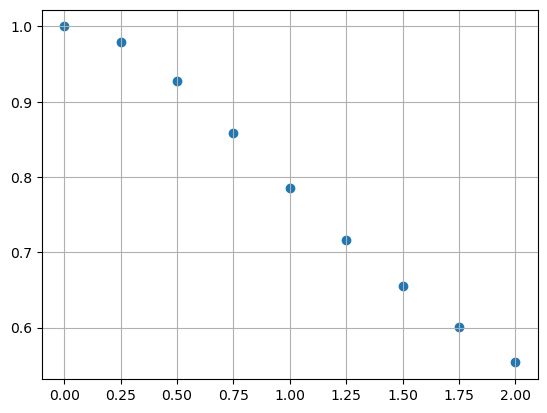

In [44]:
data = pd.read_excel('data.xlsx', header=None, usecols=[0, 1])
display(data)

x = np.array(data[0])
y = np.array(data[1])
lin = np.linspace(min(x), max(x), 200)

plt.scatter(x, y)
plt.grid()


In [45]:
def getConstantStep(x):
    dim = len(x)
    h = x[1] - x[0]
    h_m = np.full(dim, h)
    for m in range(1, dim):
        h_m[m] = x[m] - x[m-1]

    assert norm(h_m - h) < 1e-9, "x step must be constant"

    return h

def integrateTrapezoid(x, y):
    assert len(x) == len(y), 'x and y must have same size'
    dim = len(x)
    h = getConstantStep(x)

    return h * (y[0]/2 + y[dim-1]/2 + np.sum(y[1:-1]))

def integrateRichardson(x, y, integr_func, order):
    val_2h = integr_func(x[::2], y[::2])
    val_h = integr_func(x, y)

    return val_h + (val_h - val_2h) / (2**order - 1)

def integrateSimpson(x, y):
    assert len(x) == len(y), 'x and y must have same size'
    dim = len(x)
    h = getConstantStep(x)

    w = np.full(dim, 4)
    w[::2] = 2
    w[0] = w[dim-1] = 1

    return 1/3 * h * np.sum(w * y)

trapz = integrateTrapezoid(x, y)
ref_trapz = si.trapezoid(x=x, y=y)
richardson = integrateRichardson(x, y, integrateTrapezoid, 2)
simpson = integrateSimpson(x, y)
ref_simpson = sp.integrate.simpson(x=x, y=y)

print(f"Trapezoid      : {trapz}")
print(f"Trapezoid (ref): {ref_trapz}")
print(f"Richardson     : {richardson}")
print(f"Simpson        : {simpson}")
print(f"Simpson (ref)  : {ref_simpson}")


Trapezoid      : 1.5750949483751124
Trapezoid (ref): 1.5750949483751127
Richardson     : 1.5760138684425165
Simpson        : 1.5760138684425162
Simpson (ref)  : 1.5760138684425165


## Численное интегрирование с интерполяцией

VII.9.11, б)

![title](res/7-9-13.png)


,0,1
0,0.1,-2.30260
1,0.5,-0.69315
2,0.9,-0.10536
3,1.3,0.26236
4,1.7,0.53063


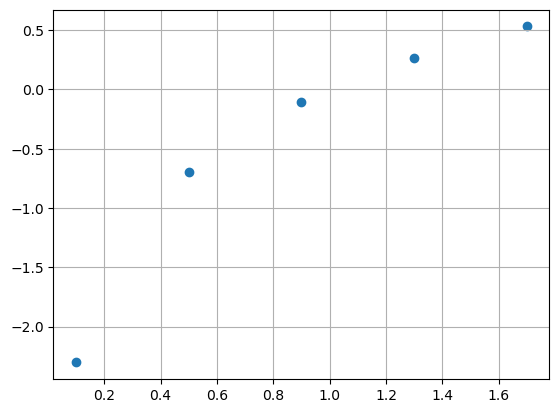

In [46]:
data = pd.read_excel('data.xlsx', header=None, usecols=[3, 4], names=[0, 1]).dropna()
display(data)

k = 80
x = np.array(data[0])
y = np.array(data[1])

plt.scatter(x, y)
plt.grid()


In [47]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

def solveTridiagonal(mat, f):
    shape = mat.shape
    dim = len(f)
    assert shape[0] == dim and shape[1] == dim, "dimensions must be equal"

    a = np.diag(mat, -1)
    b = np.diag(mat,  0).copy()
    c = np.diag(mat,  1)
    d = f.copy()

    for i in range(1, dim):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    x = np.zeros(dim)
    x[dim-1] = d[dim-1] / b[dim-1]
    for i in reversed(range(0, dim-1)):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    diff = np.matmul(mat, x) - f
    assert norm(diff) < 1e-9, 'tridiagonal method diverged, solution is incorrect'

    return x

def splineInterp(x, y):
    assert len(x) == len(y), "x and y must have same size"
    dim = len(x)

    h_m = np.zeros(dim)
    for m in range(1, dim):
        h_m[m] = x[m] - x[m-1]

    mu_m = np.zeros(dim)
    for m in range(1, dim - 1):
        mu_m[m] = h_m[m] / (h_m[m] + h_m[m+1])

    lambda_m = 1 - mu_m
    lambda_m[0] = 0

    order = len(x)
    b_im = np.zeros((order, dim))
    b_im[0] = y
    for i in range(1, order):
        prev_m = b_im[i-1]
        b_im[i][0:order-i] = [(prev_m[m+1] - prev_m[m])/(x[m+i] - x[m]) for m in range(0, order - i)]

    b_2m = b_im[2]

    d_m = np.zeros(dim)
    for m in range(1, dim - 1):
        d_m[m] = 6 * b_2m[m-1]

    mat = np.diag(np.full(dim, 2), 0) + np.diag(mu_m[1:], -1) + np.diag(lambda_m[:-1], 1)

    M_m = solveTridiagonal(mat, d_m)

    def poly(arg):
        m = np.searchsorted(x, arg)
        m = np.clip(m, 1, dim-1)
        val = M_m[m-1] * (x[m] - arg)**3 / (6 * h_m[m])                     \
              + M_m[m] * (arg - x[m-1])**3 / (6 * h_m[m])                   \
              + (y[m-1] - M_m[m-1] * h_m[m]**2 / 6) * (x[m] - arg) / h_m[m] \
              + (y[m] - M_m[m] * h_m[m]**2 / 6) * (arg - x[m-1]) / h_m[m]
        return val

    return lambda arg: poly(arg)


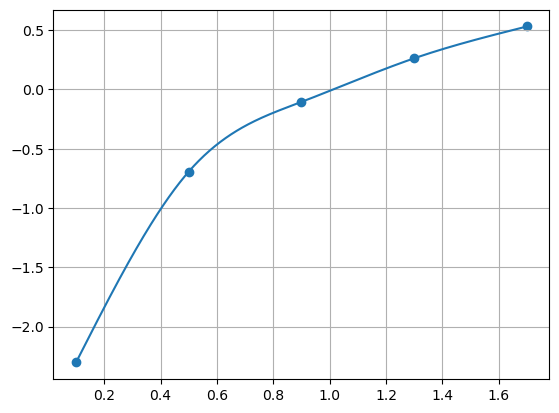

In [48]:
interp = splineInterp(x, y)

lin = np.linspace(min(x), max(x), 501)
plt.plot(lin, interp(lin))
plt.scatter(x, y)
plt.grid()


Trapezoid      : 0.00740527456352837
Trapezoid (ref): 0.007405274563528356
Richardson     : 0.007455003097294849
Simpson        : 0.0074550030972948544
Simpson (ref)  : 0.0074550030972948345


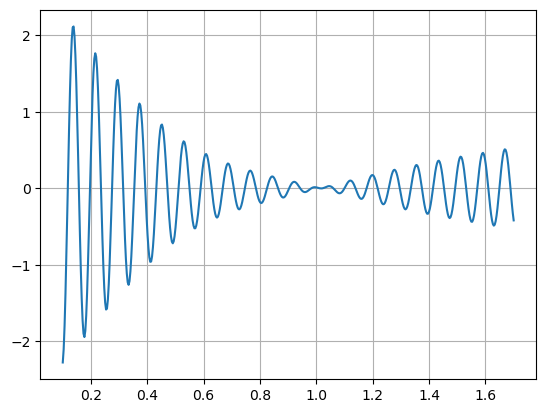

In [49]:
equ = lambda x: np.sin(k * x) * interp(x)
x = lin
y = equ(lin)

plt.plot(x, y)
plt.grid()

trapz = integrateTrapezoid(x, y)
ref_trapz = si.trapezoid(x=x, y=y)
richardson = integrateRichardson(x, y, integrateTrapezoid, 2)
simpson = integrateSimpson(x, y)
ref_simpson = sp.integrate.simpson(x=x, y=y)

print(f"Trapezoid      : {trapz}")
print(f"Trapezoid (ref): {ref_trapz}")
print(f"Richardson     : {richardson}")
print(f"Simpson        : {simpson}")
print(f"Simpson (ref)  : {ref_simpson}")
